In [1]:
import h5py
import numpy as np
import pandas as pd
import pickle as pkl
from pathlib import Path
import math

###Too complicated
import sys
import os
'''
folders = ['features','loading']
file_paths =  [Path(__file__).parent / Path(folder) for folder in folders]
for  f in file_paths:
    print(f)
    sys.path.append(f)
'''
###

from loading import load_task_data_as_pandas_df #import extract_session_data_and_save
from data import DecompData
from features import Means, Raws

%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

plt_mode = "raw" # should be from ["mean", "z_score", "raw"]
raw_course_graining = 5

force_extraction = False

data_path = Path(os.path.abspath('')).parent / Path('data')
if (not (data_path/'extracted_data.pkl').exists()) or force_extraction:
    # load behavior data
    sessions = load_task_data_as_pandas_df.extract_session_data_and_save(root_paths=[data_path], mouse_ids=["GN06"], reextract=False)
    with open( data_path/'extracted_data.pkl', 'wb') as handle:
        pkl.dump(sessions, handle)
else:
    # load saved data
    with open( data_path/'extracted_data.pkl', 'rb') as handle:
        sessions = pkl.load(handle)
    print("Loaded pickled data.")

file_path = data_path/'GN06'/'2021-01-20_10-15-16'/'SVD_data'/'Vc.mat'
f = h5py.File(file_path, 'r')

frameCnt = np.array(f['frameCnt'])
trial_starts = np.cumsum(frameCnt[:-1, 1])
svd = DecompData( sessions, np.array(f["Vc"]), np.array(f["U"]), np.array(trial_starts) )

trial_preselection = ((svd.n_targets == 6) & (svd.n_distractors == 0) &
                      (svd.auto_reward == 0) & (svd.both_spouts == 1))

print(trial_preselection.shape)
print(svd[:,:].shape)
svd_pre = svd[ trial_preselection ]

modality_keys = ['visual', 'tactile', 'vistact']
target_side_keys = ['right', 'left']

Loaded pickled data.
(696,)
(696, 17)


In [21]:
modality_id = 1
target_side = 0

# get the trials to use
selected_trials = ((svd_pre.modality == modality_id) & (svd_pre.target_side_left == target_side))

# stimulus frames
selected_frames = svd_pre[ selected_trials, 30:120 ]

# baseline frames (1sec before stimulus)
baseline_frames = svd_pre[ selected_trials, 15:30 ]

frames_corrected = Raws.create(selected_frames - Means.create( baseline_frames ))
average_frames = frames_corrected.mean.pixel[:,:,:]
print(average_frames.shape)

(90, 540, 640)


<IPython.core.display.Javascript object>


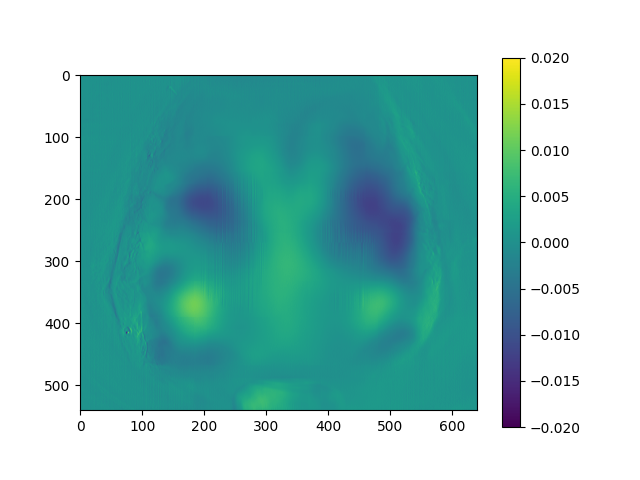

In [24]:
"""
Visualization:
"""
fig, ax = plt.subplots()

cg = raw_course_graining

ims = []

colorbar = [None]

def draw_frame(t):
    im = ax.imshow(
            np.mean( average_frames[cg*t:min(cg*(t+1),average_frames.shape[0]), :, :], axis=0),
            vmin=-0.02, vmax=0.02)
    ims.append(im)
    if colorbar[0] is None:
        colorbar[0] = fig.colorbar(im, ax=ax)


ani = FuncAnimation( fig, draw_frame, frames=math.ceil(average_frames.shape[0]/cg), interval=100, repeat=True)
#plt.show()

video = ani.to_html5_video()
#html = display.HTML(video)